In [116]:
%matplotlib inline
import matplotlib.pyplot as plt

In [117]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers
from keras import backend as K

### Replicate this Stanford tutorial :
http://ufldl.stanford.edu/wiki/index.php/Exercise:Sparse_Autoencoder

### Alternative reference :
* blog : https://github.com/EderSantana/blog/blob/master/2015-08-02%20sparse%20coding%20with%20keras.ipynb
* image patches : http://cs.stanford.edu/~jngiam/data/patches.mat

### Blog : building autoencoders in keras
https://blog.keras.io/building-autoencoders-in-keras.html

In [118]:
import math
import numpy as np
from numpy import size, reshape
from scipy.io import loadmat

In [119]:
images = loadmat('../data/natural_images.mat', matlab_compatible=False, struct_as_record=False)['IMAGES']

In [120]:
images.shape

(512, 512, 10)

In [121]:
if True: # scale in 0 to 1 range
    images = (images-np.min(images)+0.001) / (np.max(images)-np.min(images)+0.01)

In [122]:
np.min(images), np.mean(images), np.max(images)

(0.00020399208933020774, 0.41476738718704159, 0.99816407119602824)

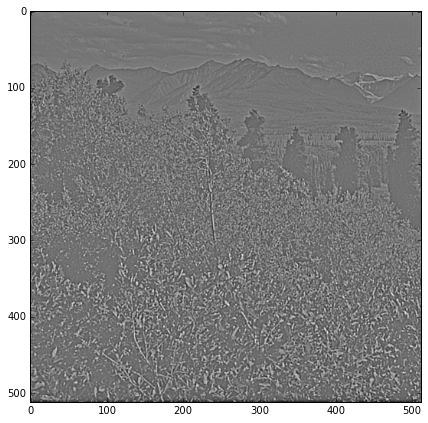

In [123]:
plt.figure(figsize=(7, 7))
plt.imshow(images[:,:,5])
plt.gray()

In [124]:
nb = 13000
cropsize = 8
Xv = np.random.randint(0, 512-cropsize, (nb), dtype='int')
Yv = np.random.randint(0, 512-cropsize, (nb), dtype='int')

Is = np.array([range(0,cropsize) for i in range(nb)]).T

Xm = (Xv+Is)
Ym = (Yv+Is)

np.tile(Xm, [cropsize,1]).shape
Cs = np.random.randint(0,10, (nb), dtype='int')

samples = images[np.tile(Xm, [cropsize,1]),
                 np.vstack([np.tile(Yv,(cropsize,1))+s for s in range(cropsize)]),
                 Cs]
samples = samples.reshape((cropsize,cropsize,-1)).transpose((1,0,2))

In [125]:
print samples.shape

(8, 8, 13000)


In [126]:
# sanity check
nb_checks = 100
for i in np.random.randint(0, nb, (nb_checks), dtype='int').tolist():
    assert (samples[:,:,i] == images[Xv[i]:(Xv[i]+cropsize),Yv[i]:(Yv[i]+cropsize),Cs[i]]).all()

In [127]:
split_index = int(nb*0.7)
x_train = samples[:,:,0:split_index].reshape((cropsize*cropsize,-1)).T # WARNING : reshape dims
print x_train.shape
x_test = samples[:,:,split_index:].reshape((cropsize*cropsize,-1)).T # WARNING : reshape dims
print x_test.shape

(9100, 64)
(3900, 64)


In [128]:
# sanity check
for i in np.random.randint(0, split_index, (nb_checks), dtype='int').tolist():
    assert (samples[:,:,i].reshape(64) == x_train[i,:]).all()

# sanity check
for i in np.random.randint(split_index, nb, (nb_checks), dtype='int').tolist():
    assert (samples[:,:,i].reshape(64) == x_test[i-split_index,:]).all()

## Basic dense layer auto-encoder

In [141]:
input_dim = cropsize*cropsize

# this is the size of our encoded representations
encoding_dim = 25

lmbd = 0.0001/input_dim; # weight decay parameter (n.b. lambda is a reserved word)

def sparse_reg(activ_matrix):
    rho = 0.01; # desired average activation of the hidden units
    beta = 3./input_dim; # weight of sparsity penalty term
    #return 1000000*K.ndim(activ_matrix) # usefull to debug
    #return 1000000*K.shape(activ_matrix)[0] # usefull to debug
    # axis 0 size is batch_size
    # axis 1 size is layer_size
    rho_bar = K.mean(activ_matrix, axis=0) # average over the batch samples
    KLs = rho*K.log(rho/rho_bar) + (1-rho)*K.log((1-rho)/(1-rho_bar))
    #return 1000000*K.shape(KLs)[0] # usefull to debug
    return beta * K.sum(KLs) # sum over the layer units

# this is our input placeholder
input_img = Input(shape=(input_dim,))

encoded = Dense(encoding_dim,
                activation='sigmoid',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                activity_regularizer=sparse_reg,
                #activity_regularizer=regularizers.l1(10e-3),
                kernel_regularizer=regularizers.l2(lmbd))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim,
                activation=None,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(lmbd))(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input_img, outputs=decoded)

# this model maps an input to its encoded representation
encoder = Model(inputs=input_img, outputs=encoded)

# create a placeholder for an encoded input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [142]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 25)                1625      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                1664      
Total params: 3,289.0
Trainable params: 3,289.0
Non-trainable params: 0.0
_________________________________________________________________


In [143]:
# train autoencoder to reconstruct MNIST digits
# use a per-pixel binary crossentropy loss

#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

def squared_error(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true-y_pred),axis=1))

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [144]:
autoencoder.optimizer.lr = 0.001

In [181]:
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128*4,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 9100 samples, validate on 3900 samples
Epoch 1/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 2/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 3/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 4/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 5/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 6/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 7/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 8/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 9/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 10/25
9100/9100 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 11/25
9100/9100

In [182]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [183]:
x_test.shape, decoded_imgs.shape

((3900, 64), (3900, 64))

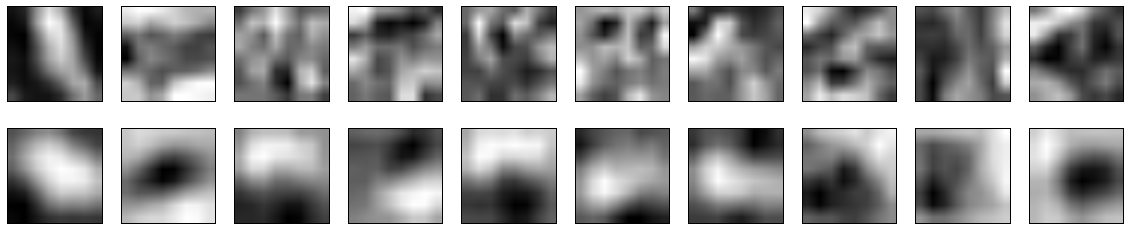

In [184]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(cropsize, cropsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(cropsize, cropsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

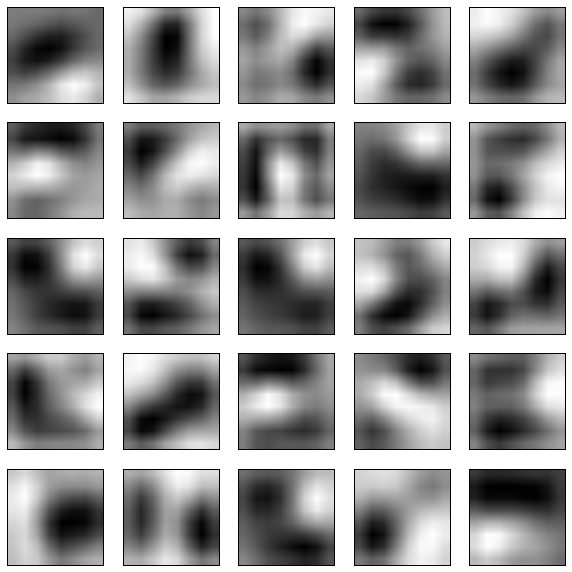

In [185]:
WEIGHTS = autoencoder.layers[1].get_weights()[0]
n = encoding_dim
grid_size = int(math.sqrt(encoding_dim))
plt.figure(figsize=(10, 10))
for i in range(grid_size*grid_size):
    # display original
    ax = plt.subplot(grid_size, grid_size, i + 1)
    plt.imshow(WEIGHTS[:,i].reshape(cropsize, cropsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()